# Datathon 2021 - Recomendador - Flow


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Datos

In [2]:
metadata = pd.read_csv("../data/metadata.csv", delimiter=";", parse_dates=['create_date', 'modify_date', 'start_vod_date', 'end_vod_date'])
train = pd.read_csv("../data/train.csv", parse_dates=['tunein', 'tuneout'])

In [5]:
metadata.content_id.nunique()

4366

## Train

Este dataset contiene los registros de visualizaciones de contenidos de Flow del formato video on demand (VOD), correspondiente a una muestra aleatoria de más de 113 mil perfiles. A continuación, se detalla el diccionario de variables de esta tabla:

- customer_id: código de identificación de cada cliente de Flow (puede tener asociados uno o más account_id)
- account_id: código de identificación de cada perfil de Flow (se corresponde con un único customer_id)
- device_type: indica el tipo de dispositivo desde el que se efectuó la visualización. Las categorías posibles son:
  - CLOUD: cliente web
  - PHONE: teléfono celular
  - STATIONARY: smart TV
  - STB: set-top box, el decodificador Flow
  - TABLET
- asset_id: código de identificación de cada activo (video) disponible en la plataforma
- tunein: fecha y hora de inicio de cada visualización
- tuneout: fecha y hora de finalización de cada visualización
- resume: variable dummy que indica si se reanuda un consumo anterior del mismo asset_id

In [3]:
train.head()

,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume
0,0,90627,STATIONARY,18332.0,2021-02-18 22:52:00,2021-02-18 23:35:00,0
1,0,90627,STATIONARY,24727.0,2021-03-24 23:17:00,2021-03-25 00:01:00,0
2,1,3387,STB,895.0,2021-03-15 10:05:00,2021-03-15 10:23:00,0
3,1,3387,STB,895.0,2021-03-15 10:23:00,2021-03-15 11:18:00,1
4,1,3387,STB,26062.0,2021-03-16 09:24:00,2021-03-16 09:44:00,0


## Metadata


Contiene la metadata asociada a cada uno de los contenidos. Las variables incluidas son:

- asset_id: código de identificación de cada activo (video) disponible en Flow
- content_id: código de identificación que agrupa los distintos asset_id asociados a un mismo contenido (por ejemplo, cada episodio de una misma serie tiene su propio asset_id, mientras que la serie se identifica con un content_id único)
- title: título
- reduced_title: título reducido
- episode_title: título del episodio (válido para contenidos episódicos, como las series)
- show_type: tipo de show - las categorías son autorreferenciales con excepción de “Rolling”, que indica que se trata de una serie incompleta, y “Web”, la cual remite a contenidos pensados íntegramente en formato digital (series web) -
- released_year: año de lanzamiento
- country_of_origin: país de origen – expresado con el código de dos letras propio del estándar internacional de normalización ISO 3166 -
- category: categoría o género al que pertenece el contenido - puede haber una o más -
- keywords: palabras clave o tags asociadas al contenido - puede haber una o más -
- description: descripción (sinopsis)
- reduced_desc: descripción (sinopsis) reducida
- cast_first_name: nombre y apellido de los actores y actrices principales
- credits_first_name: nombre y apellido del director o directora
- run_time_min: duración total, expresada en minutos
- audience: audiencia target
- made_for_tv: variable dummy que indica si el contenido fue hecho para TV
- close_caption: variable dummy que indica si el contenido posee subtítulos
- sex_rating: variable dummy que indica si el contenido tiene escenas de sexo explícitas
- violence_rating: variable dummy que indica si el contenido tiene escenas de violencia explícitas
- language_rating: variable dummy que indica si el contenido posee lenguaje que puede ser considerado ofensivo o inapropiado
- dialog_rating: variable dummy que indica si el contenido posee diálogos que pueden ser considerado ofensivos o inapropiados
- fv_rating: variable dummy que indica si el contenido tiene rating de FV, que corresponde a público infantil con violencia ficticia
- pay_per_view: variable dummy que indica si se trata de un alquiler
- pack_premium_1: variable dummy que indica si se trata de un contenido exclusivo del pack premium 1
- pack_premium_2: variable dummy que indica si se trata de un contenido exclusivo del pack premium 2
- create_date: fecha de creación del activo
- modify_date: fecha de modificación del activo
- start_vod_date: fecha desde la cual el activo se encuentra disponible en la plataforma
- end_vod_date: fecha de finalización de la disponibilidad del activo en la plataforma

In [4]:
metadata.head()

,asset_id,content_id,title,reduced_title,episode_title,show_type,released_year,country_of_origin,category,keywords,...,language_rating,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,create_date,modify_date,start_vod_date,end_vod_date
0,15188,0.0,Ep:17 Tiempos Compulsivos,Tiempos_Compul_E17,Episodio 17,Serie,2012.0,AR,Drama,"Trastornos,Médicos,Tragicómica,Telenovela,Enfe...",...,N,N,N,N,N,N,2017-12-01 10:18:15+00:00,2019-01-26 06:37:18+00:00,2017-12-01 00:00:00+00:00,2020-12-01 23:59:59+00:00
1,24940,1.0,7 Cajas,7_Cajas,NaN,Película,2012.0,PY,Suspenso/Acción,"Latinoamérica,Pobreza,Crimen,Pandillas",...,N,N,N,Y,N,N,2017-12-19 20:58:15+00:00,2019-09-17 19:02:03+00:00,2017-12-15 00:00:00+00:00,2022-12-14 23:59:59+00:00
2,21939,2.0,La Maldición de las Hormigas Gigantes,La_Maldicion_de_las,NaN,Película,2016.0,FI,Terror/Comedia,"Criaturas,Plagas,Adolescentes,Fantasía,Video J...",...,N,N,N,N,N,N,2018-02-16 13:51:07+00:00,2020-04-28 14:16:38+00:00,2018-01-25 00:00:00+00:00,2020-12-01 23:59:59+00:00
3,9005,3.0,Una Mujer Fantástica,Una_Mujer_Fantastic,NaN,Película,2017.0,CL,Drama,"LGBT,Mujeres,Latinoamérica",...,N,N,N,N,Y,N,2018-05-26 11:58:44+00:00,2019-11-15 03:00:23+00:00,2018-05-27 00:00:00+00:00,2021-04-30 23:59:59+00:00
4,7391,4.0,Star Trek,Star_Trek,NaN,Película,2009.0,US,Ciencia Ficción/Aventura,"Fantasía,Galaxia,Futurismo,Aliens,Criaturas",...,N,N,N,Y,N,N,2019-05-03 20:07:24+00:00,2020-04-09 04:37:29+00:00,2019-05-02 00:00:00+00:00,2020-12-31 23:59:59+00:00


# Análisis exploratorio de los datos

### Cantidad de clientes

In [5]:
train.customer_id.nunique()

112340

#### Cantidad de cuentas

In [6]:
train.account_id.nunique()

113881

#### Cantidad de cuentas por cliente

In [7]:
accounts_per_customer = train.groupby('customer_id').agg({'account_id': 'nunique'}).account_id

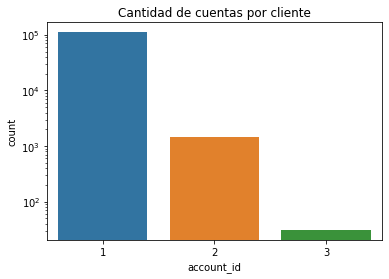

In [8]:
plt.figure()
plt.title("Cantidad de cuentas por cliente")
sns.countplot(x=accounts_per_customer)
plt.yscale('log')
plt.show()

La mayoría de los clientes tiene una sola cuenta (notar que el gráfico está con escala logarítmica).

In [9]:
accounts_per_customer.value_counts()

1    110830
2      1479
3        31
Name: account_id, dtype: int64

Hay algunos clientes que tienen hasta 3 cuentas pero son muy pocos

#### Cantidad de videos vistos por cuenta

In [10]:
assets_count = train.groupby('account_id').agg({'asset_id': 'nunique'})

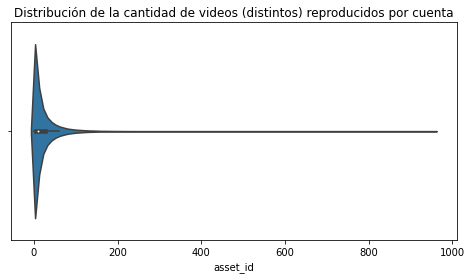

In [11]:
plt.figure(figsize=(8,4))
plt.title("Distribución de la cantidad de videos (distintos) reproducidos por cuenta")
sns.violinplot(x=assets_count.asset_id)
plt.show()

In [12]:
assets_count.asset_id.min()

0

In [13]:
assets_count.asset_id.mean()

22.740799606606895

In [17]:
assets_count.asset_id.median()

10.0

Percentil 25

In [35]:
assets_count.asset_id.quantile(0.25)

4.0

Cantidad de usuarios que vieron más de 4 videos distintos

In [36]:
assets_count[assets_count.asset_id >= 4].shape

(85678, 1)

Cantidad de usuarios que vieron un solo video

In [37]:
assets_count[assets_count.asset_id == 1].shape

(12463, 1)

In [14]:
assets_count.asset_id.max()

956

Algunas cuentas vieron 0 videos:

In [15]:
assets_count[assets_count.asset_id == 0].index

Int64Index([29416, 91253], dtype='int64', name='account_id')

In [16]:
train[train.account_id.isin([29416, 91253])]

,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume
120175,4277,29416,STB,NaN,2021-03-16 00:29:00,2021-03-16 00:36:00,0
2348268,72746,91253,STB,NaN,2021-03-27 03:32:00,2021-03-27 03:38:00,0


Estos son valores faltantes. A estas 2 cuentas (y probablemente a las que hayan visto muy pocos videos) les tendremos que buscar una solución de cold start para las recomendaciones, por ejemplo los videos más populares.

#### Device type

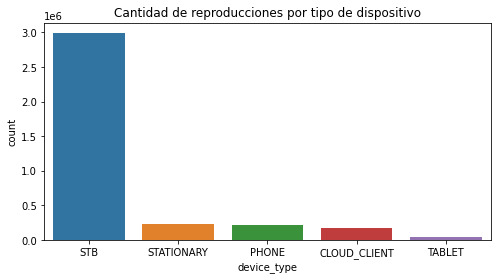

In [17]:
plt.figure(figsize=(8,4))
sns.countplot(data=train, x='device_type', order=train.device_type.value_counts().index)
plt.title("Cantidad de reproducciones por tipo de dispositivo")
plt.show()

In [18]:
train.device_type.value_counts()

STB             2993554
STATIONARY       224711
PHONE            216474
CLOUD_CLIENT     174522
TABLET            48511
Name: device_type, dtype: int64

La mayor parte de las reproducciones son desde el decodificador de flow (STB)

## Merge de train y metadata

In [19]:
train = train.merge(metadata, on='asset_id', how='left')
train.head()

,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume,content_id,title,reduced_title,...,language_rating,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,create_date,modify_date,start_vod_date,end_vod_date
0,0,90627,STATIONARY,18332.0,2021-02-18 22:52:00,2021-02-18 23:35:00,0,2040.0,T:5 Ep:08 This is Us,This_is_Us_T5_E08,...,N,N,N,N,Y,N,2021-02-18 19:05:36+00:00,2021-03-25 23:13:43+00:00,2021-02-18 00:00:00+00:00,2021-06-30 23:59:59+00:00
1,0,90627,STATIONARY,24727.0,2021-03-24 23:17:00,2021-03-25 00:01:00,0,2040.0,T:5 Ep:10 This is Us,This_is_Us_T5_E10,...,N,N,N,N,Y,N,2021-03-17 20:31:21+00:00,2021-03-25 23:15:49+00:00,2021-03-18 00:00:00+00:00,2021-06-30 23:59:59+00:00
2,1,3387,STB,895.0,2021-03-15 10:05:00,2021-03-15 10:23:00,0,1983.0,T:1 Ep:02 Big Little Lies,Big_Little_L_T1_E02,...,N,N,N,N,N,N,2021-03-05 18:37:58+00:00,2021-03-08 02:06:03+00:00,2021-03-08 00:00:00+00:00,2021-03-28 23:59:00+00:00
3,1,3387,STB,895.0,2021-03-15 10:23:00,2021-03-15 11:18:00,1,1983.0,T:1 Ep:02 Big Little Lies,Big_Little_L_T1_E02,...,N,N,N,N,N,N,2021-03-05 18:37:58+00:00,2021-03-08 02:06:03+00:00,2021-03-08 00:00:00+00:00,2021-03-28 23:59:00+00:00
4,1,3387,STB,26062.0,2021-03-16 09:24:00,2021-03-16 09:44:00,0,729.0,T:1 Ep:02 Dime quién soy,Dime_quien_s_T1_E02,...,N,N,N,N,N,N,2021-03-06 13:47:10+00:00,2021-03-08 02:06:06+00:00,2021-03-08 00:00:00+00:00,2021-03-28 23:59:00+00:00


#### Cantidad de categorías

In [20]:
train.category.nunique()

213

#### Cuantas categorías distintas vio cada cuenta?

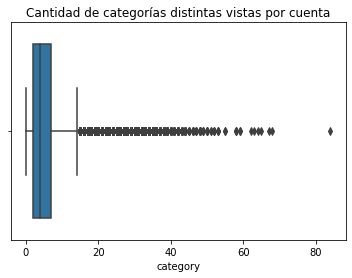

In [21]:
categories = train[['account_id', 'category']].groupby('account_id').agg({'category': 'nunique'})

plt.figure()
plt.title("Cantidad de categorías distintas vistas por cuenta")
sns.boxplot(x=categories.category)
plt.show()

#### Valores nulos

In [22]:
nulls = pd.DataFrame(train.isna().sum())
nulls.columns = ['nulls']
nulls['nulls_percentage'] = nulls['nulls'] / train.shape[0]
nulls[nulls.nulls > 0].sort_values('nulls', ascending = False)

,nulls,nulls_percentage
cast_first_name,1016037,0.277773
episode_title,885156,0.241991
credits_first_name,842844,0.230424
keywords,442,0.000121
content_id,142,0.000039
audience,131,0.000036
description,42,0.000011
country_of_origin,40,0.000011
show_type,35,0.000010
device_type,29,0.000008


#### Keywords

In [23]:
keywords = train[['account_id', 'asset_id', 'reduced_title', 'category', 'keywords']].copy()
keywords['keywords'] = keywords['keywords'].str.split(',')
keywords = keywords.explode('keywords')

In [24]:
keywords.head(15)

,account_id,asset_id,reduced_title,category,keywords
0,90627,18332.0,This_is_Us_T5_E08,Drama/Comedia,Sociedad
0,90627,18332.0,This_is_Us_T5_E08,Drama/Comedia,Tragicómica
0,90627,18332.0,This_is_Us_T5_E08,Drama/Comedia,Adicciones
0,90627,18332.0,This_is_Us_T5_E08,Drama/Comedia,Familia
0,90627,18332.0,This_is_Us_T5_E08,Drama/Comedia,Amigos
0,90627,18332.0,This_is_Us_T5_E08,Drama/Comedia,Aclamadas
0,90627,18332.0,This_is_Us_T5_E08,Drama/Comedia,Golden Globe
1,90627,24727.0,This_is_Us_T5_E10,Drama/Comedia,Sociedad
1,90627,24727.0,This_is_Us_T5_E10,Drama/Comedia,Tragicómica
1,90627,24727.0,This_is_Us_T5_E10,Drama/Comedia,Adicciones


Keywords más populares:

In [25]:
key_popularity = pd.DataFrame(keywords.keywords.value_counts()).reset_index(drop=False)
key_popularity.columns = ['keyword', 'popularity']
key_popularity.head(30)

,keyword,popularity
0,Familia,762820
1,Crimen,629987
2,Amigos,541695
3,Europa,491071
4,Aventuras,395800
5,De Libros,367733
6,Mujeres,362890
7,Animales,340869
8,Latinoamérica,316057
9,Agentes,290562


Keywords por categoría:

In [26]:
key_per_cat = keywords.groupby('category').agg({'keywords': 'unique'})
key_per_cat['nunique'] = key_per_cat['keywords'].apply(lambda x: len(x))

In [27]:
key_per_cat.sort_values(by='nunique', ascending=False).head(20)

,keywords,nunique
category,,
Drama,"[30s, Espionaje, Historia, Europa, Médicos, Mu...",181
Comedia,"[Mujeres, Superación, Amigos, Tragicómica, Cor...",146
Drama/Romance,"[Médicos, Mujeres, Época, De Libros, Remake, M...",124
Drama/Suspenso,"[Hotel, Crimen, Aislados, Latinoamérica, Mujer...",123
Documental,"[Biografía, Entrevistas, Enfermedades, Europa,...",114
Comedia/Drama,"[Amigos, Mujeres, LGBT, Adolescentes, Nueva Yo...",109
Drama/Comedia,"[Sociedad, Tragicómica, Adicciones, Familia, A...",109
Comedia/Romance,"[Nueva York, Mujeres, Amigos, 90s, Moda, Solte...",104
Drama/Crimen,"[Crimen, Abusos, Mujeres, De Libros, Feminismo...",98


#### Show type

In [28]:
train.show_type.value_counts()

Serie           1550019
TV              1178481
Película         867235
Web               32706
Rolling           26273
Gaming             2878
Tutorial            120
Series,Serie         54
Name: show_type, dtype: int64

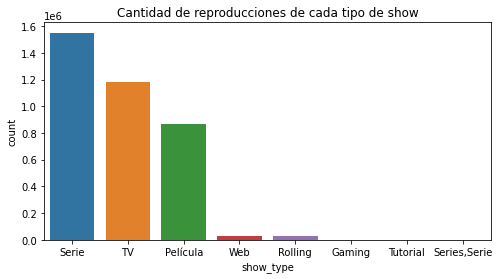

In [29]:
plt.figure(figsize=(8,4))
sns.countplot(data=train, x='show_type', order=train.show_type.value_counts().index)
plt.title("Cantidad de reproducciones de cada tipo de show")
plt.show()

"Series,Serie" debe ser transformado a "Serie"

#### Audience

In [30]:
train.audience.value_counts()

General       1546030
Mujeres        608687
Preescolar     461758
Teens          357487
Niños          256246
Juvenil        176635
Familiar       126687
Hombres        121496
NIños            2636
Gaming              8
Name: audience, dtype: int64

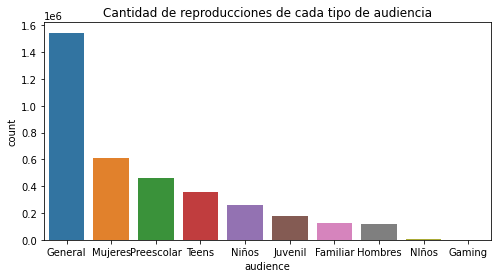

In [31]:
plt.figure(figsize=(8,4))
sns.countplot(data=train, x='audience', order=train.audience.value_counts().index)
plt.title("Cantidad de reproducciones de cada tipo de audiencia")
plt.show()

#### close_caption, sex_rating, violence_rating, language_rating,dialog_rating, fv_rating

In [32]:
train.close_caption.unique()

array(['N', nan], dtype=object)

In [33]:
train.sex_rating.unique()

array(['N', nan], dtype=object)

In [34]:
train.violence_rating.unique()

array(['N', nan], dtype=object)

In [35]:
train.language_rating.unique()

array(['N', nan], dtype=object)

In [36]:
train.dialog_rating.unique()

array(['N', nan], dtype=object)

In [37]:
train.fv_rating.unique()

array(['N', nan], dtype=object)

Todas estas variables pueden ser descartadas

#### Consistencia de categorías

Hay videos que aparezcan con categorías/keywords/audience distintos?

In [38]:
distinct_categories = train[['content_id', 'category', 'keywords', 'audience']]\
                        .groupby(['content_id'])\
                        .agg({'category': 'nunique', 'keywords': 'nunique', 'audience': 'nunique'})
distinct_categories.head()

,category,keywords,audience
content_id,,,
0.0,1,1,1
1.0,1,1,1
3.0,1,1,1
6.0,1,1,1
7.0,1,1,1


Cantidad de videos distintos:

In [39]:
distinct_categories.shape[0]

4064

Cantidad de videos que tienen más de una categoría:

In [40]:
distinct_categories[distinct_categories.category > 1].shape[0]

89

Cantidad de videos que tienen más de un grupo de keywords:

In [41]:
distinct_categories[distinct_categories.keywords > 1].shape[0]

348

Cantidad de videos que tienen más de un tipo de audiencia:

In [42]:
distinct_categories[distinct_categories.audience > 1].shape[0]

61

Análisis de videos con más de una categoría:

In [44]:
video_multiple_categories = train[train.content_id.isin(distinct_categories[distinct_categories.category > 1].index.values)]
video_multiple_categories = video_multiple_categories[['content_id', 'title', 'category', 'modify_date']].drop_duplicates()
video_multiple_categories.sort_values(by='content_id')

,content_id,title,category,modify_date
7069,162.0,Hotel Transylvania 2,Infantil/Animación,2020-12-02 01:33:47+00:00
269346,162.0,Hotel Transylvania 2,Comedia,2020-12-12 15:06:05+00:00
359392,288.0,Colateral: Lugar y tiempo equivocado,Acción/Drama,2021-01-01 04:06:08+00:00
63121,288.0,Colateral,Drama/Crimen,2020-12-20 22:06:13+00:00
5325,302.0,La Sospecha,Suspenso/Drama,2020-12-20 14:06:10+00:00
18463,302.0,La sospecha,Drama/Suspenso,2020-10-20 05:06:06+00:00
988789,403.0,Terminator Génesis,Acción,2021-01-26 11:25:48+00:00
1642,403.0,Terminator: Génesis,Acción/Ciencia Ficción,2020-12-24 02:06:09+00:00
264800,403.0,Terminator génesis,Acción/Ciencia Ficción,2020-08-25 07:06:07+00:00
177070,476.0,Camino a Estambul,Drama/Acción,2020-12-20 12:06:04+00:00


Viendo en general, suele cambiar la categoría pero la mayor parte de las veces cambia el orden de las palabras. Por ejemplo: 
- Acción/Aventura -> Aventura/Acción

Análisis videos con más de un tipo de audiencia:

In [45]:
video_multiple_aud = train[train.content_id.isin(distinct_categories[distinct_categories.audience > 1].index.values)]
video_multiple_aud = video_multiple_aud[['content_id', 'title', 'audience', 'modify_date']].drop_duplicates()
video_multiple_aud.sort_values(by='content_id')

,content_id,title,audience,modify_date
3621732,61.0,T:1 Ep:12 Hércules,Teens,2020-12-04 17:06:05+00:00
62025,61.0,T:1 Ep:04 Hércules,Niños,2021-03-16 10:06:52+00:00
62006,61.0,T:1 Ep:65 Hércules,Niños,2021-02-19 12:06:09+00:00
62004,61.0,T:1 Ep:63 Hércules,Niños,2021-02-18 00:06:12+00:00
62000,61.0,T:1 Ep:62 Hércules,Niños,2021-02-12 23:06:11+00:00
61999,61.0,T:1 Ep:61 Hércules,Niños,2021-02-12 19:06:09+00:00
61998,61.0,T:1 Ep:60 Hércules,Niños,2021-02-11 18:15:08+00:00
353669,61.0,T:1 Ep:02 Hércules,Niños,2021-03-03 15:42:26+00:00
9514,61.0,T:1 Ep:31 Hércules,Teens,2020-12-05 17:06:03+00:00
9519,61.0,T:1 Ep:33 Hércules,Teens,2021-01-07 06:06:03+00:00


In [46]:
video_multiple_aud = train[train.content_id.isin(distinct_categories[distinct_categories.audience > 1].index.values)]
video_multiple_aud = video_multiple_aud[['content_id', 'audience']].groupby(['content_id']).agg({'audience': 'unique'})
video_multiple_aud.sort_values(by='content_id')

,audience
content_id,
61.0,"[Teens, Niños]"
82.0,"[Teens, Niños]"
99.0,"[Preescolar, Teens]"
106.0,"[Teens, Niños]"
288.0,"[General, Hombres]"
303.0,"[Mujeres, General]"
476.0,"[Hombres, General]"
557.0,"[General, Juvenil]"
792.0,"[Mujeres, General]"


Vemos que a veces cambia el tipo de audiencia.

El resto suele cambiar por "General". Hay que analizar si vale la pena incluir el audience = General.

#### Keywords null y nan

In [50]:
train[train.keywords.isna()].shape[0]

442

In [58]:
non_nulls = train[train.keywords.notna()]

In [68]:
non_nulls[non_nulls.keywords == '']

,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume,content_id,title,reduced_title,...,language_rating,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,create_date,modify_date,start_vod_date,end_vod_date


No tenemos casos con keyword = string vacío

In [71]:
non_nulls[non_nulls.keywords.str.contains('null')][['keywords']].head()

,keywords
308,"Pandillas,Medioambiente,Thriller,null,Terroris..."
327,"Parejas,Latinoamérica,null"
814,"Parejas,Latinoamérica,null"
1017,"Aventuras,null"
1021,"Aventuras,null"


In [67]:
non_nulls[non_nulls.keywords.str.contains('null')][['keywords']].shape[0]

19327

Muchos casos contienen una keyword: "null"

# Conclusiones de EDA

- Si se usa **show_type** "Series,Serie" debe ser transformado a "Serie"
- En keywords hay que limpiar la palabra "null"

Para el recomendador se va a entrenar un clasificador de fasttext (supervised): https://fasttext.cc/docs/en/support.html

## Primeras 2 iteraciones:

### 1) keywords, audiences, categories

El dataset se armará de la siguiente forma:

- x:[distinct keywords seen by the user, distinct audiences seen by the user, distinct categories seen by the user ]
- Y: content_id

Para predecir al modelo se le pasará X y de los resultados de la predicción se sacarán los contenidos ya vistos por el usuario.

Para usuarios que no tienen visualizaciones se utilizará la solución cold start.


### 2) content_ids 

El dataset se armará de la siguiente forma:

Por cada usuario, tenemos una lista de content ids vistos. Para cada una de estas listas se arman las combinaciones de modo que tengamos una fila con cada id usado como label. Por ejemplo:

Usuario A vio: 1,2,3,4.

Dataset:

2 3 4 __ label__1

1 3 4 __ label__2

1 2 4 __ label__3

1 2 3 __ label__4

Y asi por cada usuario.

Para predecir, al modelo se le pasaría el listado de ids visto por el usuario y se aplicaría el mismo filtro y cold start que en V1.